En este cuaderno voy a hacer una análisis del dataset dreams.csv el cual contiene una colección de más de 20000 observaciones de sueños.

Este dataset lo he bajdo ed la siguiente dirección:
http://www.dreambank.net/

**PIPELINE**:

  * Análisis de los datos 
  * Preparación de datos para algoritmo LDA
  * Topic Modelling
  * Dream Generator

# **IMPORTACIÓN LIBRERIAS Y SOFTWARE**

In [34]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install gensim
!pip install pyLDAvis
!pip install stop_words
!python -m textblob.download_corpora
!pip install textblob
!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt

!pip install tensorflow==1.14.0

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
--2020-04-01 16:09:08--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolvi

In [35]:
import numpy as np
import pandas as pd
import json
import io
import spacy
import re
from google.colab import files
from stop_words import get_stop_words
from string import punctuation
from gensim.corpora import Dictionary
from gensim import corpora, models, similarities
import pyLDAvis.gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from termcolor import colored
import warnings
from PIL import Image as Image2
from wordcloud import WordCloud
from os import path, getcwd
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
slang = pd.read_csv("slang.txt", header=None, encoding = 'latin1', delimiter="\t")
slang.columns = ['Abbreviation', 'Text']
slang_dict = dict([(Abbreviation, Text) for Abbreviation, Text in zip(slang.Abbreviation, slang.Text)])
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **ANÁLISIS DE LOS DATOS**

In [36]:
!git clone https://gitlab.com/davidllorenteraposo/proyectofinalkcdll.git

fatal: destination path 'proyectofinalkcdll' already exists and is not an empty directory.


In [0]:
dreams_df = pd.read_csv('proyectofinalkcdll/data/dreams.csv',encoding="ISO-8859-1")

In [0]:
dreams_df.head()

content  ...    y_umap
0  In my dream, the first thing I remember was th...  ...  1.124417
1  The next thing I know, I'm in this big, fairly...  ...  1.664258
2  Last night's dreams are a little fuzzy in my m...  ...  1.473029
3  I woke up this morning knowing I had a dream i...  ...  0.798065
4  I remember being in Africa- a quiet wooded sce...  ...  1.046098

[5 rows x 33 columns]

In [0]:
print(f"El dataset contiene {len(dreams_df)} observaciones de sueños y {dreams_df.shape[1]} columnas")

El dataset contiene 26343 observaciones de sueños y 33 columnas


Del dataset nos vamos a quedar con las columnas correspondientes a la descripción del sueño y al propietario del mismo.

Para nuestro análisis no necesitamos nada mas

Descripción del sueño: **content**

propietario: **dream_series_id**

Vemos unas cuantas observaciones

In [0]:
dreams_columns=["content","dream_series_id"]

In [0]:
dreams_df=dreams_df[dreams_columns]

Nuestro objetivo va a ser ver con que sueñan los sujetos del dataset por ello nuestra label será la variable **dream_series_id** con la que predeciremos los sueños

In [0]:
np.unique(dreams_df['dream_series_id'])

array(['alta', 'angie', 'arlie', 'b', 'b-baseline', 'b2',
       'bay_area_girls_456', 'bay_area_girls_789', 'bea1', 'bea2',
       'blind-f', 'blind-m', 'bosnak', 'chris', 'chuck', 'dahlia',
       'david', 'dorothea', 'ed', 'edna', 'elizabeth', 'emma',
       'emmas_husband', 'esther', 'hall_female', 'izzy0', 'izzy12',
       'izzy13', 'izzy14', 'izzy15', 'izzy16', 'izzy17', 'izzy18',
       'jasmine1', 'jasmine2', 'jasmine3', 'jasmine4', 'jeff', 'joan',
       'kenneth', 'lawrence', 'mack', 'madeline1-hs', 'madeline2-dorms',
       'madeline3-offcampus', 'madeline4-postgrad', 'mark', 'melissa',
       'melora', 'melvin', 'merri', 'miami-home', 'miami-lab',
       'midwest_teens-f', 'midwest_teens-m', 'nancy', 'natural_scientist',
       'norman', 'norms-f', 'norms-m', 'pegasus', 'peru-f', 'peru-m',
       'phil1', 'phil2', 'phil3', 'physiologist', 'ringo', 'samantha',
       'seventh_graders', 'toby', 'tom', 'ucsc_women', 'vickie',
       'vietnam_vet', 'vietnam_vet2', 'wedding', 'w

Vemos un pequeño analisis de los datos

In [0]:
print(dreams_df.info())
print(dreams_df.shape)
print(dreams_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26343 entries, 0 to 26342
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   content          26343 non-null  object
 1   dream_series_id  26343 non-null  object
dtypes: object(2)
memory usage: 411.7+ KB
None
(26343, 2)
                                             content dream_series_id
0  In my dream, the first thing I remember was th...            jeff
1  The next thing I know, I'm in this big, fairly...            jeff
2  Last night's dreams are a little fuzzy in my m...            jeff
3  I woke up this morning knowing I had a dream i...            jeff
4  I remember being in Africa- a quiet wooded sce...            jeff


Podemos ver que lo siguiente:
  * tenemos 26343 tweets
  * no hay datos nulos
  * tenemos 2 columnas
  * los datos de tweets necesitan un preprocesado

Si queremos ver una pequeña grafica de la distribución de los sueños, para ver quien tiene mas observaciones podemos ver aqui.

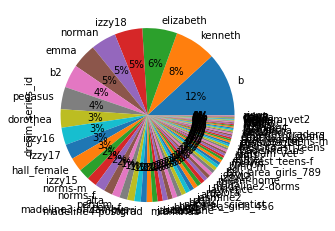

In [0]:
dreams_df.dream_series_id.value_counts().plot(kind='pie', autopct='%1.0f%%')  

Vemos que hay muchos soñadores y que un tal 'b' sueña el 12% de las observaciones, nos vamos a centrar en el para predecir que sueña

# **LIMPIEZA DE LOS DATOS**

Vamos a hacer una serie de transformaciones y de limpieza de los datos para que la descripción de los sueños llegue lo mas limpio posible antes de hacer el encoding a numrico para el algoritmo.

A primera vista parece que los datos estan mas limpios que en otras ocasiones , por ejemplo analisis de tweet,que se usan muchas contracciones, jerga y simbolos

**Eliminamos duplicados si los hubiera**

In [0]:
dreams_df = dreams_df.drop_duplicates()

Parece que hemos eliminado un registro, algo es algo!

In [0]:
dreams_df.shape

(26342, 2)

**Tratamiento de nulos si los hbiera**

Su hubiera alguna columna con nulos la elimino para no entorpecer al algoritmo

In [0]:
# Función para calcular los missings
def missing_values(df):
        # Total
        mis_val = df.isnull().sum()
        
        # Porcentaje
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Hago la tabla
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Ordeno
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
       
        print ("El dataframe seleccionado tiene " + str(df.shape[1]) + " columnas.\n"      
            "Existen " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas que tienen missings.")
        
        # Return 
        return mis_val_table_ren_columns
missing_values(dreams_df)

El dataframe seleccionado tiene 2 columnas.
Existen 0 columnas que tienen missings.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

**Funciones de limpieza**

Me creo una serie de funciones que me van a ayudar a limpiar los datos y mostrar los resultados

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
def preprocesado(text):
  for word in text.split():
    # Convert more than 2 letter repetitions to 2 letter
    text = text.replace(word, re.sub(r'(.)\1+', r'\1\1', word))
  for word in text.split():
    # Removing Special Characters.
    text = text.replace(word, re.sub('[^a-zA-z0-9\s]', ' ', word))
  for word in text.split():
    # Remove punctuation
    text = text.replace(word, word.strip('\'"?!,.():;'))
  return text
def compute_coherence(model):
  coherence = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  return coherence.get_coherence()

Realizamos las transformaciones sobre el contenido de los sueños

In [0]:
# Convert to lower case
dreams_df['content'] = dreams_df['content'].apply(lambda x: x.lower())
# Replaces URLs
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', x))
# Replace @handle
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'@[\S]+', '', x))
# Replaces #hashtag with hashtag
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'#(\S+)', r' \1 ', x))
# Remove RT (retweet)
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'\brt\b', '', x))
# Replace 2+ dots with space
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'\.{2,}', ' ', x))
# Strip space, " and ' from tweet
dreams_df['content'] = dreams_df['content'].apply(lambda x: x.strip(' "\''))
# Replace multiple spaces with a single space
dreams_df['content'] = dreams_df['content'].apply(lambda x: re.sub(r'\s+', ' ', x))
# Remove Stop Words
stop = stopwords.words('english')
dreams_df['content'] = dreams_df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

**Slang words**

En todos los idiomas existen jergas (slang), estas palabras deben de ser tratadas para el correcto funcionamiento del modelo.

Vamos a limpiar los datos quitando abreviaturas. Siempre sabiendo que el idioma es inglés.

Podemos ver la lista de abreviaturas, con esta lista vamos a reemplazar las que existan en nuestros datos.

In [0]:
# Reemplazo slang y abreviaciones
def checkSlangWords(text):
  for word in text.split():
    if word.lower() in slang_dict:
      text = text.replace(word, slang_dict[word.lower()])
  return(text)
dreams_df['content'] = dreams_df['content'].apply(lambda x: checkSlangWords(x))

**Contracciones del lenguaje**

Eliminamos las contracciones del lenguaje.

Me he copiado las del idioma ingles y me he creado un diccionario

In [0]:
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", 
    "can't've": "cannot have", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
    "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
    "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
    "i'll've": "i will have","i'm": "i am", "i've": "i have", 
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
    "it'll": "it will", "it'll've": "it will have","it's": "it is", 
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
    "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
    "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is",
    "that'd": "that would", "that'd've": "that would have","that's": "that is", 
    "there'd": "there would", "there'd've": "there would have","there's": "there is", 
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
    "they'll've": "they will have", "they're": "they are", "they've": "they have", 
    "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
    "we're": "we are", "we've": "we have", "weren't": "were not", 
    "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
    "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", 
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", 
    "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

In [0]:
#Reemplazo contracciones
def checkContractionWords(text):
  for word in text.split():
    if word.lower() in contractions:
      text = text.replace(word, contractions[word.lower()])
  return(text)
dreams_df['content'] = dreams_df['content'].apply(lambda x: checkContractionWords(x))

**Preprocesado de datos**

In [0]:
dreams_df['content'] = dreams_df['content'].apply(lambda x: preprocesado(x))

**STEAMMING**

Reducimos a la raiz de la palabra para aligerar

In [0]:
# STEAMMING
ps = PorterStemmer()
dreams_df['content'] = dreams_df['content'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))

**LEMMATIZACION**

Buscamos la correspondiente forma flexionada usando lematización de las palabras

In [0]:
# LEMMATIZACION
lmtzr = WordNetLemmatizer()
dreams_df['content'] = dreams_df['content'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))

**Borramos palabras no repetidas y tweets vacios**

In [0]:
words_one = pd.Series(' '.join(dreams_df['content']).split()).value_counts().where(lambda x : x==1).dropna().index
dreams_df['content'] = dreams_df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in words_one))
dreams_df = dreams_df.loc[dreams_df['content']!='']

**TOKENIZAMOS**

In [0]:
dreams_df['content'] = dreams_df['content'].apply(lambda x: nltk.word_tokenize(x))

Vemos como nos han quedado nuestros sueños

In [0]:
print(dreams_df.head(10))
print(dreams_df.shape)

                                             content dream_series_id
0  [dream, first, thing, rememb, nerdi, guy, goe,...            jeff
1  [next, thing, know, i, be, big, fairli, dark, ...            jeff
2  [last, night, s, dream, littl, fuzzi, mind, re...            jeff
3  [wake, morn, know, dream, immedi, rememb, abou...            jeff
4  [rememb, africa, quiet, wood, scene, outdoor, ...            jeff
5  [dream, walk, middl, new, york, citi, yet, rea...            jeff
6  [first, memori, see, blond, girl, look, famili...            jeff
7  [walk, hospit, peopl, life, support, cord, con...            jeff
8  [rememb, realli, involv, dream, like, movi, i,...            jeff
9  [dream, take, place, night, i, be, run, contin...            jeff
(26341, 2)


### **TOPIC MODELLING**

En el aprendizaje automático y el procesamiento del lenguaje natural, un modelo de topic es un tipo de modelo estadístico para descubrir los "temas" abstractos que ocurren en una colección de documentos.

De tal modo vamos a hacer este analisis de los sueños de los pacienyes del dataset.

Primero en general y luego del soñador 'b' que analizamos antes el cual tenía una cantidad de sueños mayor que el resto de soñadores

**Topic modelling común**

Usaremos la librería nltk y corpora para crearnos el diccionario y el corpus para alimentar al algoritmo

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

Nos creamos el documento

In [0]:
dreams_documents = []
for row in dreams_df.iterrows():
    _, info = row
    text, _ = info
    #text = [t.text for t in nlp(text.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    dreams_documents.append(text)

In [0]:
print(f'El tamaño del documento de sueños es de {len(dreams_documents)}')

El tamaño del documento de sueños es de 26341


Ahora nos creamos el diccionario

In [0]:
dreams_dictionary = corpora.Dictionary(dreams_documents)
dreams_corpus = [dreams_dictionary.doc2bow(text) for text in dreams_documents]
dreams_texts = dreams_df['content'].values

Una vez que tenemos el diccionario y los documentos definimos nuestro **modelo LDA**

En aprendizaje automático, la Asignación Latente de Dirichlet o Latent Dirichlet Allocation es un modelo generativo que permite que conjuntos de observaciones puedan ser explicados por grupos no observados que explican porqué algunas partes de los datos son similares

In [0]:
def LDAmodelDreams(num_topics, iterations=1, passes=1):
  return models.ldamodel.LdaModel(dreams_corpus, id2word=dreams_dictionary, num_topics=num_topics, 
                                  random_state=32, eval_every=10, chunksize=1500, 
                                  passes=1, iterations=1, 
                                  per_word_topics=True, alpha='auto')

Nos creamos una función de computo de coherencia de los valores.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
def compute_coherence(model):
  coherence = models.CoherenceModel(model=model, texts=dreams_texts, dictionary=dreams_dictionary, coherence='c_v')
  return coherence.get_coherence()

Ponemos un límite de 20 topics

In [0]:
limit=20; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=dreams_dictionary, corpus=dreams_corpus, texts=dreams_documents, start=start, limit=limit, step=step)

**Visualizamos los datos**

Habría que alcanzar un compromiso para poner un número de topics que no solapen mucho la visualización pero que no sean tan pocos como para que la coherencia sea baja.

Para esto podemos  buscar el número de topics de forma manual o con esta función

Primero buscamos de forma automática

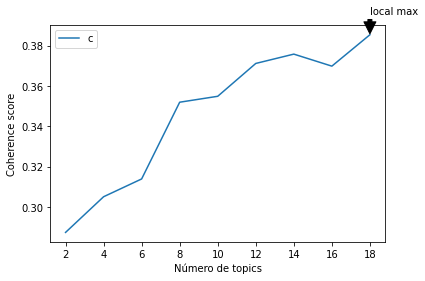

In [0]:
x = range(start, limit, step)
plt.plot(x, coherence_values)

ymax = max(coherence_values)
xpos = coherence_values.index(ymax)
xmax = x[xpos]
plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+0.01),
            arrowprops=dict(facecolor='green', shrink=0.05))
            
plt.xlabel("Número de topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Nos devuelve el máximo de topics óptimo

In [0]:
print(f'El número de topics óptimo es de {model_list[xpos].num_topics}')

El número de topics óptimo es de 18


Y de forma manual con este código, debemos elegir el número óptimo de topics nosotros

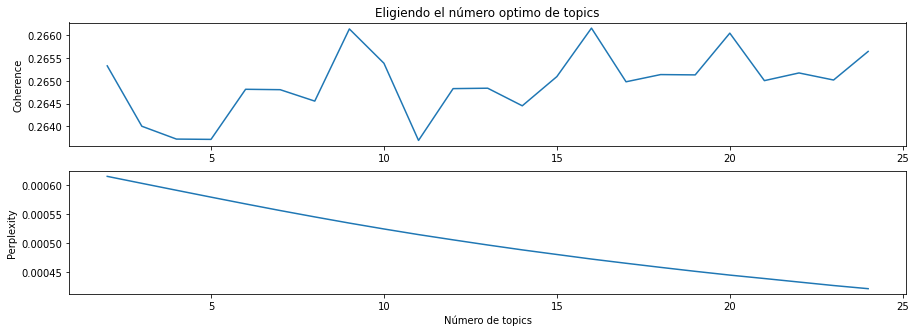

In [0]:
coherences = []
perplexity = [] 

for num_topics in range(2, 25):
  lda_modelDreams = LDAmodelDreams(num_topics, iterations=5, passes=20)
  coherences.append(compute_coherence(lda_modelDreams))
  perplexity.append(lda_modelDreams.log_perplexity(dreams_corpus))

plt.figure(figsize=(15, 5))

plt.subplot(211)
plt.title('Eligiendo el número optimo de topics')
plt.ylabel('Coherence')
plt.plot(range(2, 25), coherences)

plt.subplot(212)
plt.plot(range(2, 25), np.exp(perplexity))
plt.xlabel('Número de topics')
plt.ylabel('Perplexity')
plt.show()

PARECE ACERTADO ELEGIR 8 TOPICS YA QUE LA COHERENCIA ES ALTA Y LA PERPLEJIDAD BAJA 

Visualizamos los resultados

In [0]:
dreams_lda = model_list[xpos]
print(dreams_lda.bound(dreams_corpus))
vis = pyLDAvis.gensim.prepare(dreams_lda, dreams_corpus, dreams_dictionary)
pyLDAvis.display(vis)

-15938995.215837449


Podemos ver las 5 primeras palabras de cada topic

In [0]:
topicsDreams = dreams_lda.print_topics(num_words=5)
for topic in topicsDreams:
  print(topic)


(0, '0.035*"boy" + 0.034*"one" + 0.030*"build" + 0.026*"us" + 0.021*"group"')
(1, '0.045*"man" + 0.038*"see" + 0.031*"me" + 0.030*"sit" + 0.025*"woman"')
(2, '0.046*"guy" + 0.028*"girl" + 0.028*"peopl" + 0.018*"ladi" + 0.017*"watch"')
(3, '0.046*"think" + 0.041*"know" + 0.038*"go" + 0.031*"someth" + 0.030*"would"')
(4, '0.126*"say" + 0.039*"tell" + 0.035*"ask" + 0.033*"talk" + 0.031*"want"')
(5, '0.057*"school" + 0.040*"class" + 0.028*"high" + 0.020*"book" + 0.019*"write"')
(6, '0.027*"babi" + 0.022*"bathroom" + 0.012*"return" + 0.012*"must" + 0.011*"frank"')
(7, '0.086*"hous" + 0.066*"s" + 0.037*"home" + 0.031*"bed" + 0.029*"live"')
(8, '0.029*"wear" + 0.027*"dress" + 0.023*"cloth" + 0.019*"blue" + 0.019*"chang"')
(9, '0.101*"like" + 0.049*"go" + 0.032*"thing" + 0.031*"mom" + 0.022*"dream"')
(10, '0.081*"get" + 0.056*"go" + 0.039*"back" + 0.031*"car" + 0.029*"run"')
(11, '0.057*"water" + 0.023*"tree" + 0.021*"boat" + 0.020*"swim" + 0.017*"fish"')
(12, '0.045*"tabl" + 0.039*"eat" + 0.0

Es basante dificil saber de que hablan los sueños es la realidad, así que con un modelo  bastante ás, aún de esta forma ahi podemos ver los 17 topics de los que se sueña

**Topic modelling de usuario b (BEATRIZ)**

Al inicio del análisis veíamos la distribución de frecuencias de sueños de los soñadores y veíamos que un tbal b tenía la de media mas sueños que los demás.

Vamos a ver que sueña b.

Primero vamos a cambiar el nomre de B por Beatriz para que sea mas normal

In [0]:
dreams_df.replace({'dream_series_id' : 'b'}, 'Beatriz', inplace=True)

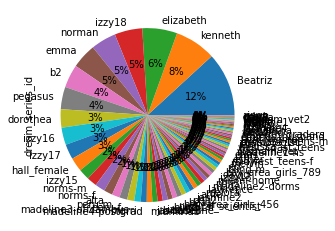

In [0]:
dreams_df.dream_series_id.value_counts().plot(kind='pie', autopct='%1.0f%%') 

Voy a analizar por separado con que sueña Beatriz

No creamos el documento

In [0]:
documentsBeatriz = []
for row in dreams_df[dreams_df['dream_series_id'] == "Beatriz"].iterrows():
    _, info = row
    text, _ = info
    #text = [t.text for t in nlp(text.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documentsBeatriz.append(text)

Nos craemos el diccionario

In [0]:
vocab = set([t for doc in documentsBeatriz for t in doc])
w2id = {k:i for  i,k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}

dictBeatriz = Dictionary(documentsBeatriz)
print('dictBeatriz',len(dictBeatriz))

9464 unique tokens
dictBeatriz 9464


Y nos creamos el corpus

In [0]:
corpusBeatriz = [dictBeatriz.doc2bow(doc) for doc in documentsBeatriz]

Vamos a buscar de nuevo el número óptimo de topics para beatriz

In [0]:
limit=20; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=dictBeatriz, corpus=corpusBeatriz, texts=documentsBeatriz, start=start, limit=limit, step=step)

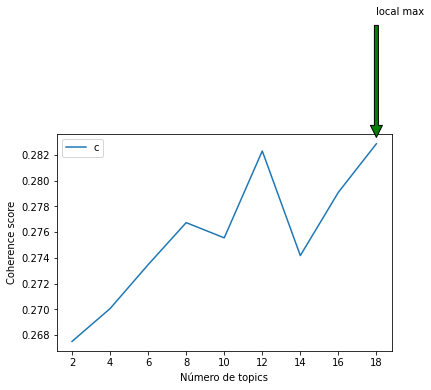

In [0]:
x = range(start, limit, step)
plt.plot(x, coherence_values)

ymax = max(coherence_values)
xpos = coherence_values.index(ymax)
xmax = x[xpos]
plt.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+0.01),
            arrowprops=dict(facecolor='green', shrink=0.05))
            
plt.xlabel("Número de topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Vemos que ha vuelto a salir que con 18 topics tenemos un buen resultado

In [0]:
dreams_lda_Beatriz = model_list[xpos]
print(dreams_lda_Beatriz.bound(corpusBeatriz))
vis = pyLDAvis.gensim.prepare(dreams_lda_Beatriz, corpusBeatriz, dictBeatriz)
pyLDAvis.display(vis)

-2200077.923216343


Vamos a ver de que hablan los sueños de Beatriz

In [0]:
topicsBeatriz = dreams_lda_Beatriz.print_topics(num_words=4)
for topic in topicsBeatriz:
  print(topic)

(0, '0.030*"car" + 0.027*"drive" + 0.025*"get" + 0.017*"go"')
(1, '0.033*"get" + 0.018*"go" + 0.017*"i" + 0.014*"tri"')
(2, '0.020*"want" + 0.019*"say" + 0.016*"see" + 0.016*"be"')
(3, '0.029*"be" + 0.026*"see" + 0.018*"room" + 0.017*"go"')
(4, '0.047*"say" + 0.024*"i" + 0.016*"be" + 0.013*"want"')
(5, '0.048*"man" + 0.028*"get" + 0.023*"woman" + 0.022*"be"')
(6, '0.027*"like" + 0.017*"look" + 0.015*"go" + 0.014*"see"')
(7, '0.018*"go" + 0.018*"see" + 0.016*"take" + 0.013*"back"')
(8, '0.031*"i" + 0.021*"say" + 0.018*"be" + 0.016*"feel"')
(9, '0.046*"i" + 0.046*"be" + 0.028*"say" + 0.014*"tell"')
(10, '0.017*"see" + 0.017*"go" + 0.017*"look" + 0.015*"like"')
(11, '0.019*"water" + 0.018*"go" + 0.016*"see" + 0.014*"one"')
(12, '0.033*"say" + 0.021*"look" + 0.019*"like" + 0.018*"go"')
(13, '0.026*"go" + 0.020*"i" + 0.019*"be" + 0.016*"get"')
(14, '0.025*"go" + 0.024*"say" + 0.019*"write" + 0.014*"be"')
(15, '0.021*"go" + 0.018*"see" + 0.015*"stage" + 0.014*"say"')
(16, '0.045*"room" + 0.0

Podemos sacar una nube de palabras que identifica a los topics de los sueños de Beatriz.

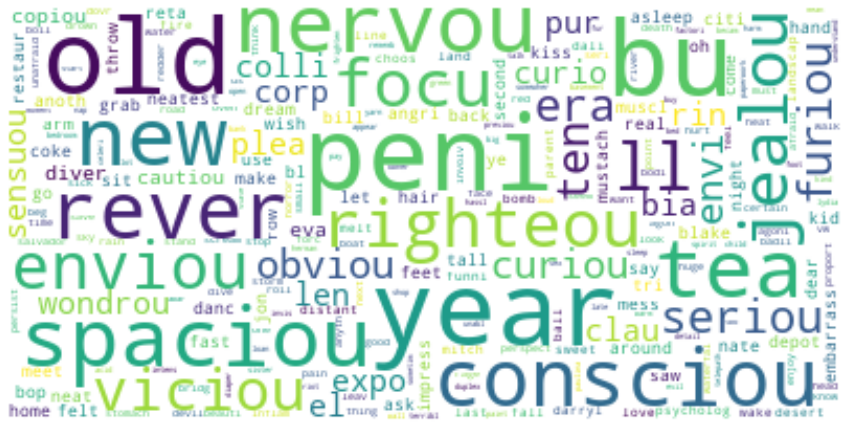

In [0]:
beatriz_dreams = dictBeatriz.values()
wc = WordCloud(background_color="white", max_words=250,
               max_font_size=50, random_state=42)
wc.generate((' '.join(beatriz_dreams)))

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **DREAM GENERATOR**

Por último vamos a usar languaje modelling para generar sueños de Beatriz.

Vamos a volver a limpiar los datos .

In [0]:
dreams2_df = pd.read_csv('proyectofinalkcdll/data/dreams.csv',encoding="ISO-8859-1")

In [0]:
dreams2_df.replace({'dream_series_id' : 'b'}, 'Beatriz', inplace=True)

In [0]:
dreams_columns=["content"]
dreams2_df=dreams2_df[dreams_columns]

In [40]:
dreams2_df.head()

content
0  In my dream, the first thing I remember was th...
1  The next thing I know, I'm in this big, fairly...
2  Last night's dreams are a little fuzzy in my m...
3  I woke up this morning knowing I had a dream i...
4  I remember being in Africa- a quiet wooded sce...

He hecho pruebas con el dataset completo y el modelo tarda mucchisimoen compilar, lo que nones viable para estas pruebas.

He decido hacer un sample de losdatos para que elalgorimo entrene mas rápido y no me tire la sesion por faltta de RAM

**Tu sesión ha fallado porque se ha usado toda la memoria RAM disponible. Obtener más memoria RAM**

Cuando le llega al padding un maxlenght algo alto no puede mantener la RaM y tira la sesion.

Debe haber algunos sueñloscon un número muy grande y no lo acepta..

Voy a intentar hacer un sample de los datos y con una semilla diferente para que aleatorize estos

In [0]:
seed=np.random.seed(124)
dreams2_df = dreams2_df.sample(n=50, random_state=seed)

Limpieza y transformaciones del dataset

In [0]:
def transformaciones_generales():
  # Quito espacios al inicio y al final del texto
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.strip()) 

  #Convierto el texto a lowerCase
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: textSent.lower())

  #Reemplazamod entidades HTML
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&amp;', '& '))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&lt;', '<'))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&gt;', '>'))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&circ;', '^'))


  #Eliminar RT (retweet)
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: re.sub(r'\brt\b', '', textSent))

  #Reemplazo 2puntos por espacio
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: re.sub(r'\.{2,}', ' ', textSent))

  #" and ' from tweet
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: textSent.strip(' "\''))

  #Reemplazo muchos espacios por solo uno
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: re.sub(r'\s+', ' ', textSent))

  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&ensp;', ' '))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&thinsp;', ' '))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&emsp;', ' '))

  # &ndash; 	&mdash; -> '-'
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&ndash;', '-'))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&mdash;', '-'))

  # ' &quot; &lsquo; &rsquo; &sbquo; &ldquo; &rdquo; &bdquo; &lsaquo; &rsaquo;  -> "'"
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('"', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&quot;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&lsquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&rsquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&sbquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&ldquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&rdquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&bdquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&lsaquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&rsaquo;', "'"))
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&quot;', "'"))

  # Signo del euro
  dreams2_df['content'] = dreams2_df['content'].map(lambda textSent: textSent.replace('&euro;', '€'))

  #Elimino caracteres únicos
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: re.sub(r'\s+[a-zA-Z]\s+', ' ', textSent))

  #Elimino caracteres únicos del inicio
  dreams2_df['content'] = dreams2_df['content'].apply(lambda textSent: re.sub(r'\^[a-zA-Z]\s+', ' ', textSent))

  return dreams2_df

In [0]:
dreams2_df=transformaciones_generales()

Trato los datos suplicados

In [44]:
dreams2_df=dreams2_df.drop_duplicates()
dreams2_df.shape

(50, 1)

**Language modelling**

Nos creamos una lista de sueños de Beatriz y las separamos por /n

In [0]:
dreams2_df_dreams = dreams2_df['content'].tolist()
dreams = ""
for e in dreams2_df_dreams:
    dreams += e + '\n'

**Tokenizamos.**

Usaremos modelo One-Word-In, One-Word-Out Sequences

In [0]:
nlp = spacy.load('en_core_web_sm')
tokenizerTG = Tokenizer()
tokenizerTG.fit_on_texts(dreams2_df_dreams)
wordTG = len(tokenizerTG.word_index) + 1

Nos creamos el documento con los tokens creados anteriormente

In [0]:
documentTG = []
for line in dreams2_df_dreams:
		token_list = tokenizerTG.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			documentTG.append(n_gram_sequence)

**Padding**

Pasamos a matrizes las secuencias de números de nustros tokens mediante pad_sequence

In [0]:
max_sequence_len = max([len(x) for x in documentTG])
documentTG = np.array(pad_sequences(documentTG, maxlen=max_sequence_len, padding='pre'))

nos creamos nuetras features y label

In [0]:
dream_pred, dream_label = documentTG[:,:-1],documentTG[:,-1]
dream_label = ku.to_categorical(dream_label, num_classes=wordTG)

Ahora es momento de crearnos el modelo, vamos  a usar el algoritmo LSTM.


In [51]:
modelDreams = Sequential()
modelDreams.add(Embedding(wordTG, 10, input_length=max_sequence_len-1))
modelDreams.add(LSTM(100))
modelDreams.add(Dense(wordTG, activation='softmax'))
print(modelDreams.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 417, 10)           17450     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_3 (Dense)              (None, 1745)              176245    
Total params: 238,095
Trainable params: 238,095
Non-trainable params: 0
_________________________________________________________________
None


Compilamos el modelo y entrenamos 100 épocas

In [52]:
modelDreams.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=0, mode='auto')
modelDreams.fit(dream_pred, dream_label, epochs=100, verbose=1, callbacks=[earlystop])

Epoch 1/100
7501/7501 [==============================] - 71s 9ms/step - loss: 6.5326 - accuracy: 0.0449
Epoch 2/100
7501/7501 [==============================] - 71s 9ms/step - loss: 6.1089 - accuracy: 0.0473
Epoch 3/100
7501/7501 [==============================] - 72s 10ms/step - loss: 6.0472 - accuracy: 0.0533
Epoch 4/100
7501/7501 [==============================] - 72s 10ms/step - loss: 5.9720 - accuracy: 0.0592
Epoch 5/100
7501/7501 [==============================] - 71s 9ms/step - loss: 5.9118 - accuracy: 0.0676
Epoch 6/100
7501/7501 [==============================] - 71s 9ms/step - loss: 5.8399 - accuracy: 0.0697
Epoch 7/100
7501/7501 [==============================] - 71s 9ms/step - loss: 5.7669 - accuracy: 0.0744
Epoch 8/100
7501/7501 [==============================] - 72s 10ms/step - loss: 5.6880 - accuracy: 0.0737
Epoch 9/100
7501/7501 [==============================] - 72s 10ms/step - loss: 5.6114 - accuracy: 0.0787
Epoch 10/100
7501/7501 [==============================] - 72

Vemos la salida de nuestra LSTM que en la época 50 ya ha alcanzado el 50% de accuracy...seguramente llegará hasta el 80 por lo menos.

7501/7501 [==============================] - 68s 9ms/step - loss: 1.2943 - accuracy: 0.7244
Epoch 88/100
7501/7501 [==============================] - 67s 9ms/step - loss: 1.2699 - accuracy: 0.7303
Epoch 89/100
7501/7501 [==============================] - 66s 9ms/step - loss: 1.2471 - accuracy: 0.7352
Epoch 90/100
7501/7501 [==============================] - 67s 9ms/step - loss: 1.2235 - accuracy: 0.7418
Epoch 91/100
7501/7501 [==============================] - 67s 9ms/step - loss: 1.1975 - accuracy: 0.7476
Epoch 92/100
7501/7501 [==============================] - 68s 9ms/step - loss: 1.1766 - accuracy: 0.7562
Epoch 93/100
7501/7501 [==============================] - 68s 9ms/step - loss: 1.1570 - accuracy: 0.7596
Epoch 94/100
7501/7501 [==============================] - 69s 9ms/step - loss: 1.1359 - accuracy: 0.7670
Epoch 95/100
7501/7501 [==============================] - 69s 9ms/step - loss: 1.1134 - accuracy: 0.7712
Epoch 96/100
7501/7501 [==============================] - 69s 9ms/step - loss: 1.0916 - accuracy: 0.7743
Epoch 97/100
7501/7501 [==============================] - 69s 9ms/step - loss: 1.0794 - accuracy: 0.7816
Epoch 98/100
7501/7501 [==============================] - 68s 9ms/step - loss: 1.0486 - accuracy: 0.7888
Epoch 99/100
7501/7501 [==============================] - 68s 9ms/step - loss: 1.0307 - accuracy: 0.7922
Epoch 100/100
7501/7501 [==============================] - 67s 9ms/step - loss: 1.0103 - accuracy: 0.7948

<keras.callbacks.callbacks.History at 0x7fdcdac49e80>

Si manipulamos los hiperparámetros, cambiamos la NN añadiendole capas, tunning de hiperparametros seguramente mejoraríamos el rendiemiento de la misma

Nos creamos una función para unificar la generación e texto y que nos salga impreso ,dada una frase al azar la continuación del tweet que ha generado el algoritmo.

Inicio de frase: init_tweet --> le decimos como empieza el tweet

Siguiente palabra_ next_w --> le indicamos que palabra sigue

Tamaño maximo de la secuencia: max_sequence_len

Modelo

In [0]:
def dreamGenerator(init_tweet, next_w, max_sequence_len, model):
    for j in range(next_w):
        token_list = tokenizerTG.texts_to_sequences([init_tweet])[0]
        token_list = pad_sequences([token_list], maxlen= 
                             max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizerTG.word_index.items():
            if index == predicted:
                output_word = word
                break
        init_tweet += " " + output_word
    return init_tweet

Una vez que el algoritmo ha entrenado vamos a probar como genera nuevos sueños:

In [56]:
print (dreamGenerator("i have a dream", 18, max_sequence_len, modelDreams))

i have a dream and on this there is sleeping in the fireplace it's to get my wedding trousseau we the friend


También podemos comparar los sujeños originales con los que nos ha generado ela algorimto

In [0]:
def lenCorpus(dream):
  numTokens = ""
  for x in dreams2_df_dreams[dream].strip().split(' '):
    numTokens=numTokens+x+" "
  return numTokens.split(" ")[0:3]

In [75]:
for i in range(10):
  sueñoOriginal=lenCorpus(i)[0] +" "+ lenCorpus(i)[1]+" "+lenCorpus(i)[2]
  print(f'Sueño original: {dreams2_df_dreams[i]}')
  print (f'Sueño generado {dreamGenerator(sueñoOriginal, 20, max_sequence_len, modelDreams)}')
  print()

Sueño original: i was living in house with my mother and sister. the house resembled one we lived in, in my hometown. lay on high bed in dimly lit room. the bed was by window, and looked out into the yard. felt very nostalgic as looked out, as recalled living there before.
Sueño generado i was living in house with my mother and sister the house resembled one is number of the palms of pair of hands

Sueño original: instructions from ironman am with my co-workers, the chicken catchers from the early crew. we have guns. have .22. they have shotguns. some of the guys are shooting clay pigeons. somehow, clay pigeon flies towards me, and i'm afraid i'll get shot. wince. the catchers yell to me, 'smother it!', or 'kick it!' they want me to go right up to it and shoot. there is huge bull there. ironman, one of the catchers, comes up to me. think he is going to tell me how to shoot. protest, saying i'm catcher and that don't shoot guns. but he says, 'look, kenneth ' and continues to give me ins